<a href="https://colab.research.google.com/github/plodha/CMPE-297-DeepLearning/blob/main/Notebook/AnoGAN_Inference_Metric_AllCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Set Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.7.0 torchvision==0.5.0 tqdm opencv-python Pillow==8.0.1 tensorboardX==1.4

     |████████████████████████████████| 4.0MB 8.8MB/s 
     |████████████████████████████████| 2.2MB 60.2MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.7.0+cu101 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
!nvidia-smi

Mon Dec  7 00:29:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls

drive  sample_data


In [3]:
import argparse
import os
import numpy as np
import math
import sys
import random
import pandas as pd
#import torchvision.transforms as transforms
from torchvision.utils import save_image
#from dataloader.dataloader import load_data
#from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
#from networks import Generator, Discriminator
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import torch
import cv2
ngpu = 1
os.makedirs("images", exist_ok=True)

In [17]:
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import numpy as np

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage import measure



In [4]:
from torch.utils.data import DataLoader, Dataset
class MURA_dataset(Dataset):
    '''
    Dataset class for MURA dataset
    Args:
        - df: Dataframe with the first columns contains the path to the images
        - root_dir: string contains path of  root directory
        - transforms: Pytorch transform operations
    '''

    def __init__(self, df, root_dir, transforms=None):
        #print("I am calling Mura dataset")
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        #print('img_name ',img_name)
        img = cv2.imread(img_name)
        #print('img shape ',img.shape)

        if self.transforms:
            img = self.transforms(img)

        if 'negative' in img_name: label = 0
        else: label = 1

        return img, label

In [5]:
def transform(rotation, hflip, resize, totensor, normalize, centercrop, to_pil, gray):
    options = []
    if to_pil:
        options.append(torchvision.transforms.ToPILImage())
    if gray:
        options.append(torchvision.transforms.Grayscale())
    if rotation:
        options.append(torchvision.transforms.RandomRotation(20))
    if hflip:
        options.append(torchvision.transforms.RandomHorizontalFlip())
    if centercrop:
        options.append(torchvision.transforms.CenterCrop(256))
    if resize:
        options.append(torchvision.transforms.Resize((32,32)))
    if totensor:
        options.append(torchvision.transforms.ToTensor())
    # if True:
    #     options.append(transforms.Lambda(lambda x: (x - x.min())/(x.max()-x.min())))
    if normalize:
        options.append(torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    transform = torchvision.transforms.Compose(options)
    return transform

In [6]:
def customDf(path, studyClass=None, studyType=None):
    '''
    Function to get custom csv based on class of study and type of study
    Args:
        - path(string): path to original csv
        - studyClass(list): class of study, list must contains one of the following:
            "XR_ELBOW",
            "XR_FINGER",
            "XR_FOREARM",
            "XR_HAND",
            "XR_HUMERUS",
            "XR_SHOULDER",
            "XR_WRIST"
            if None, take all
        - studyResult(list): Result of study, list must contains one of the following:
            "positive", "negative"
            if None, take all
    '''
    df = pd.read_csv(path, header=None)

    if studyClass:
        cond = df[0].str.contains(studyClass)
        df = df[cond]
    if studyType:
        cond = df[0].str.contains(studyType)
        df = df[cond]
    return df

In [ ]:
#import pandas as pd
#import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
#transforms = transform(False, True, True, True, True, True, True, False)


#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)

In [ ]:
#valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, dim, zdim, nc):
        super(Generator, self).__init__()
        self.nc = nc
        self.dim = dim
        preprocess = nn.Sequential(
            nn.Linear(zdim, 4 * 4 * 4 * dim),
            nn.BatchNorm1d(4 * 4 * 4 * dim),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * dim, 2 * dim, 2, stride=2),
            nn.BatchNorm2d(2 * dim),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * dim, dim, 2, stride=2),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(dim, nc, 2, stride=2)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * self.dim, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, self.nc, 32, 32)

# Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, dim, zdim, nc, out_feat=False):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.dim = dim
        main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
        )
        self.out_feat=out_feat
        self.main = main
        self.linear = nn.Linear(4*4*4*dim, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*self.dim)
        if self.out_feat:
            return output
        output = self.linear(output)
        return output


class Encoder(nn.Module):
     def __init__(self,dim, zdim, nc):
         super(Encoder, self).__init__()
         self.dim = dim
         main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            )
         self.main = main
         self.linear = nn.Linear(4*4*4*dim, zdim)

     def forward(self, input):
         output = self.main(input)
         output = output.view(-1, 4*4*4*self.dim)
         output = self.linear(output)
         return output

# Inference

## Category 
arr = ["XR_ELBOW","XR_FINGER","XR_FOREARM","XR_HAND","XR_HUMERUS","XR_SHOULDER","XR_WRIST"]

In [11]:
from PIL import Image
import numpy as np

In [12]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

## 1.XR_ELBOW

In [13]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_ELBOW', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [14]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


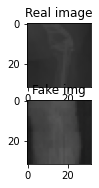

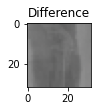

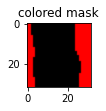

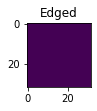

Number of Contours found = 0
im3:  (32, 32, 3)


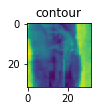

torch.Size([465])

######## Category: XR_ELBOW #######
roc_auc= 0.5275083056478405
max_auc= 0.5275083056478405
465


In [22]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_ELBOW/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
            im = tensor2im(imgs)
            
            im2 = tensor2im(fake_imgs)
            print(lbls)
            
            im3 = tensor2im(diff)
            plt.figure(1)
            plt.subplot(311)
            plt.title('Real image')
            plt.imshow(im)

            plt.subplot(312)
            plt.title('Fake img')
            plt.imshow(im2)
            plt.show()
            
            img = cv2.GaussianBlur(im3,(5,5),0)
            img_gray = rgb2gray(img)
            plt.imshow(img_gray)
            thresh = threshold_otsu(img_gray)
            binary = img_gray > thresh
            
            plt.imshow(binary)
            im_rgb = np.array(Image.fromarray(binary).convert('RGB'))
            mask = binary.copy()
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
            
            mask3 = np.stack((mask,mask,mask), axis=2)

            all_labels = measure.label(mask)
            all_labels[all_labels >= 1] = 255
            all_labels[all_labels < 1] = 0
            all_labels3 = np.stack((all_labels,all_labels,all_labels), axis=2)
            
           
            
            
#             kernel = np.ones((6, 6), np.uint8) 
  
#             # Using cv2.erode() method  
#             image = cv2.erode(Image.fromarray(mask3), kernel, cv2.BORDER_REFLECT) 
        
            black_pixels_mask = np.all(mask3 == 1, axis=2)
            non_black_pixels_mask = np.any(mask3 > [0, 0, 0], axis=-1)
          
            all_labels3[non_black_pixels_mask] = [255,0,0]
            
            plt.subplot(313)
            plt.title('Difference')
            plt.imshow(im3)
            plt.show()
            
            plt.subplot(321)
            plt.title('colored mask')
            plt.imshow(all_labels3)
            plt.show()
            
            
            
            gray = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY) 
  
            # Find Canny edges 
            edged = cv2.Canny(gray, 30, 200) 
           

            # Finding Contours 
            # Use a copy of the image e.g. edged.copy() 
            # since findContours alters the image 
            contours, hierarchy = cv2.findContours(edged,  
                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

            plt.subplot(322)
            plt.imshow(edged)
            plt.title('Edged')
            plt.show()
            

            print("Number of Contours found = " + str(len(contours))) 

            # Draw all contours 
            # -1 signifies drawing all contours 
            print('im3: ',im3.shape)
            backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
            cv2.drawContours(gray, contours, -1, (0, 255, 0), 3) 
            backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

          
            plt.subplot(323)
            plt.title('contour')
            plt.imshow(gray)
            plt.show()
            Image.fromarray(gray).save('backtorgb.jpg')
           
            break    
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_ELBOW #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 2.XR_FINGER

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_FINGER', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(0.0002, device='cuda:0')
torch.Size([461])

######## Category: XR_FINGER #######
roc_auc= 0.9261363636363636
max_auc= 0.9261363636363636
461


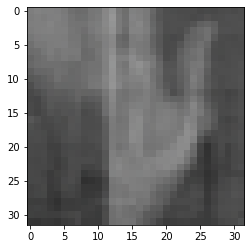

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_FINGER/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_FINGER #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 3.XR_FOREARM

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_FOREARM', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(0.0002, device='cuda:0')
torch.Size([301])

######## Category: XR_FOREARM #######
roc_auc= 0.9324966078697422
max_auc= 0.9324966078697422
301


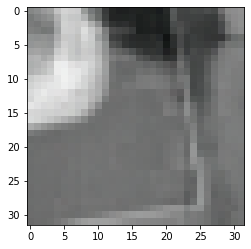

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_FOREARM/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_FOREARM #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 4.XR_HAND

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_HAND', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

In [ ]:
from torch.nn.functional import mse_loss

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(0.0002, device='cuda:0')
torch.Size([460])

######## Category: XR_HAND #######
roc_auc= 0.7800925925925927
max_auc= 0.7800925925925927
460


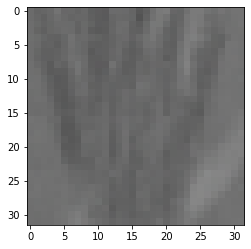

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_HAND/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_HAND #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 5.XR_HUMERUS

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

In [ ]:
from torch.nn.functional import mse_loss

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(0.0002, device='cuda:0')
torch.Size([288])

######## Category: XR_HUMERUS #######
roc_auc= 0.912128877646119
max_auc= 0.912128877646119
288


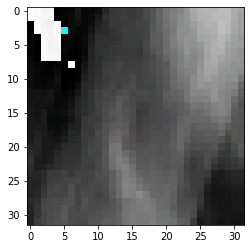

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_HUMERUS/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_HUMERUS #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 6.XR_SHOULDER

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_SHOULDER', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

In [ ]:
from torch.nn.functional import mse_loss

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(6.9595e-05, device='cuda:0')
torch.Size([563])

######## Category: XR_SHOULDER #######
roc_auc= 0.8893190921228304
max_auc= 0.8893190921228304
563


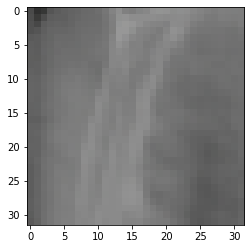

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_SHOULDER/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_SHOULDER #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))

## 7.XR_WRIST

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_WRIST', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

### Metric Computation

In [ ]:
from torch.nn.functional import mse_loss

(32, 32, 3)
(32, 32, 3)
torch.Size([64, 128]) torch.Size([64, 128])
z_distance= tensor(3.8494e-05, device='cuda:0')
torch.Size([659])

######## Category: XR_WRIST #######
roc_auc= 0.9753515301902399
max_auc= 0.9753515301902399
659


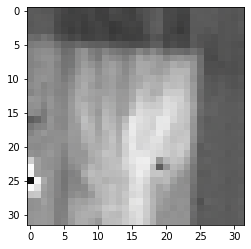

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
#device = 'cuda' 
out = '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/AnoGAN/models/anoGAN-ckpts-XR_WRIST/' #scs- change here for all cat

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)
            emb_fake = encoder(fake_imgs)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)
            print(emb_query.shape, emb_fake.shape)
            z_distance = mse_loss(emb_query, emb_fake)#mse_loss(emb_query, emb_fake)
            #print z_distance
            print('z_distance=',z_distance)
            #print('hiiiiiiiii')
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)
            break

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)

    #print('\n####################')
    print('\n######## Category: XR_WRIST #######')
    
    
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print('roc_auc=', roc_auc)
    max_auc = max(roc_auc, max_auc)
    print('max_auc=', max_auc)
    
    print(len(valid_dataloader.dataset))